# COMP90086 Workshop 6

***
In this worksheet, we'll implement and investigate a Vision Transformer model, and implement a popular CNN visualisation method (Grad-CAM).


### Table of Contents

- Vision Transformer (ViT)

- Grad-CAM visualization

In [1]:
from packaging import version

import os
import cv2
import zipfile
import numpy as np
import requests
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras import ops
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

# you may want to keep logging enabled when doing your own work
# disable Tensorflow warnings for this tutorial
import logging
tf.get_logger().setLevel(logging.ERROR) 
# disable Keras warnings for this tutorial
import warnings
warnings.simplefilter("ignore") 

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


# 1 Vision Transformer (ViT)

In this section, we'll classify images with a pretrained ViT and investigate how the ViT model represents images.

Code source: https://keras.io/examples/vision/probing_vits/

## Classifying images with ViT

This code is designed to work with more than one ViT. This section defines appropriate parameters and pre-processing steps for individual ViT models.

In [2]:
RESOLUTION = 224
PATCH_SIZE = 16
#GITHUB_RELEASE = "https://github.com/sayakpaul/probing-vits/releases/download/v1.0.0/probing_vits.zip"
#FNAME = "probing_vits.zip"
#MODELS_ZIP = {
#    "vit_dino_base16": "Probing_ViTs/vit_dino_base16.zip",
#    "vit_b16_patch16_224": "Probing_ViTs/vit_b16_patch16_224.zip",
#    "vit_b16_patch16_224-i1k_pretrained": "Probing_ViTs/vit_b16_patch16_224-i1k_pretrained.zip",
#}

crop_layer = keras.layers.CenterCrop(RESOLUTION, RESOLUTION)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)
rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)


def preprocess_image(image, model_type, size=RESOLUTION):
    # Turn the image into a numpy array and add batch dim.
    image = np.array(image)
    image = ops.expand_dims(image, 0)

    # If model type is vit rescale the image to [-1, 1].
    if model_type == "original_vit":
        image = rescale_layer(image)

    # Resize the image using bicubic interpolation.
    resize_size = int((256 / 224) * size)
    image = ops.image.resize(image, (resize_size, resize_size), interpolation="bicubic")

    # Crop the image.
    image = crop_layer(image)

    # If model type is DeiT or DINO normalize the image.
    if model_type != "original_vit":
        image = norm_layer(image)

    return ops.convert_to_numpy(image)

Load the pretrained ViT

In [3]:
#zip_path = keras.utils.get_file(
#    fname=FNAME,
#    origin=GITHUB_RELEASE,
#)

#with zipfile.ZipFile(zip_path, "r") as zip_ref:
#    zip_ref.extractall("./")

#os.rename("Probing ViTs", "Probing_ViTs")


def load_model(model_path: str) -> keras.Model:
    with zipfile.ZipFile(model_path, "r") as zip_ref:
        zip_ref.extractall("Probing_ViTs/")
    model_name = model_path.split(".")[0]

    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    model = keras.layers.TFSMLayer(model_name, call_endpoint="serving_default")
    outputs = model(inputs, training=False)

    return keras.Model(inputs, outputs=outputs)


vit_base_i21k_patch16_224 = load_model("Probing_ViTs/vit_b16_patch16_224-i1k_pretrained.zip")
print("Model loaded.")

Model loaded.


Load the mapping from ImageNet class numbers to text labels.

In [4]:
# Map the ImageNet class numbers to text class labels
mapping_file = keras.utils.get_file(
    origin="https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
)

with open(mapping_file, "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]

Load an image and display it.

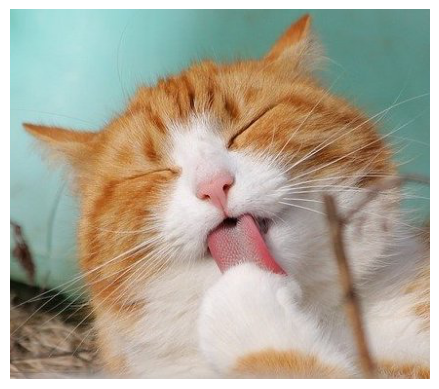

In [5]:
img = "cat.jpg"
image = keras.utils.load_img(img)
preprocessed_image = preprocess_image(image, model_type="original_vit")

plt.imshow(image)
plt.axis("off")
plt.show()

Classify the image using the pretrained VIT and ImageNet class labels.

In [6]:
def split_prediction_and_attention_scores(outputs):
    predictions = outputs["output_1"]
    attention_score_dict = {}
    for key, value in outputs.items():
        if key.startswith("output_2_"):
            attention_score_dict[key[len("output_2_") :]] = value
    return predictions, attention_score_dict


predictions, attention_score_dict = split_prediction_and_attention_scores(
    vit_base_i21k_patch16_224.predict(preprocessed_image)
)
predicted_label = imagenet_int_to_str[int(np.argmax(predictions))]
print(predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
tabby, tabby_cat


### Exercise 1

Replace the sample image above with your own image examples. How accurate are the classification results?

## Attention distance

Because CNNs learn convolutional kernels, they are restricted to learning local features in their early layers. Each layer can only learn features in small window corresponding to the footprint (or "receptive field") of its kernels. ViTs do no have this restriction and can learn features that are widely-separated in the image, even in their earliest layers. What size of features do ViTs learn?

We can investigate this by looking at the "mean attention distance," which is defined the image (Euclidean) distance between each pair of tokens, times the attention weight for that pair.

In [7]:
def compute_distance_matrix(patch_size, num_patches, length):
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j:  # zero distance
                continue

            xi, yi = (int(i / length)), (i % length)
            xj, yj = (int(j / length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix


def compute_mean_attention_dist(patch_size, attention_weights, model_type):
    num_cls_tokens = 2 if "distilled" in model_type else 1

    # The attention_weights shape = (batch, num_heads, num_patches, num_patches)
    attention_weights = attention_weights[
        ..., num_cls_tokens:, num_cls_tokens:
    ]  # Removing the CLS token
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert length**2 == num_patches, "Num patches is not perfect square"

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape

    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    # The attention_weights along the last axis adds to 1
    # this is due to the fact that they are softmax of the raw logits
    # summation of the (attention_weights * distance_matrix)
    # should result in an average distance per token.
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(
        mean_distances, axis=-1
    )  # Sum along last axis to get average distance per token
    mean_distances = np.mean(
        mean_distances, axis=-1
    )  # Now average across all the tokens

    return mean_distances

Compute mean attention distance for each of the 12 attention heads in each layer (block) of the Vision Transformer:

Num Heads: 12.


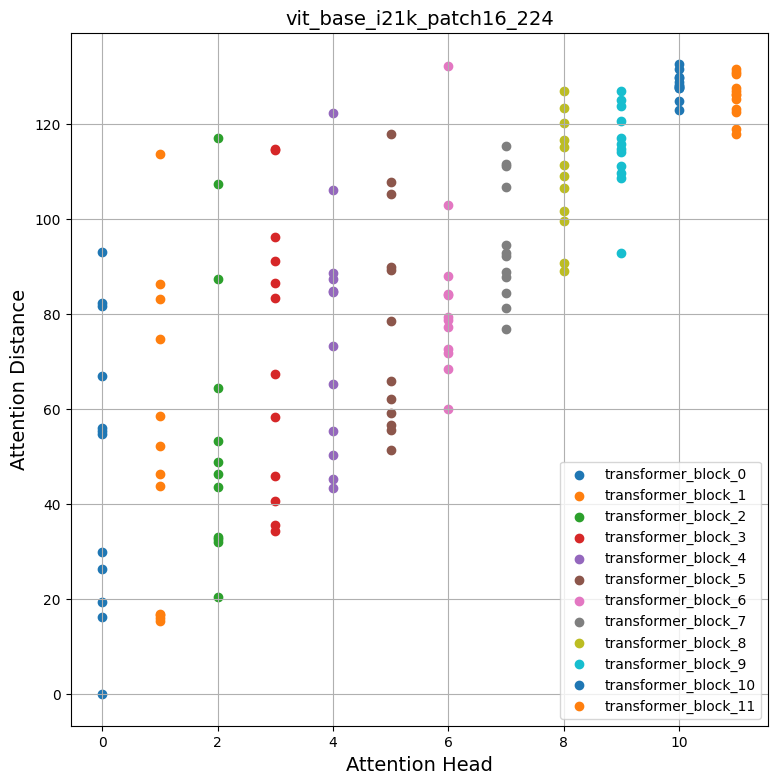

In [8]:
# Build the mean distances for every Transformer block.
mean_distances = {
    f"{name}_mean_dist": compute_mean_attention_dist(
        patch_size=PATCH_SIZE,
        attention_weights=attention_weight,
        model_type="original_vit",
    )
    for name, attention_weight in attention_score_dict.items()
}

# Get the number of heads from the mean distance output.
num_heads = mean_distances["transformer_block_0_att_mean_dist"].shape[-1]

# Print the shapes
print(f"Num Heads: {num_heads}.")

plt.figure(figsize=(9, 9))

for idx in range(len(mean_distances)):
    mean_distance = mean_distances[f"transformer_block_{idx}_att_mean_dist"]
    x = [idx] * num_heads
    y = mean_distance[0, :]
    plt.scatter(x=x, y=y, label=f"transformer_block_{idx}")

plt.legend(loc="lower right")
plt.xlabel("Attention Head", fontsize=14)
plt.ylabel("Attention Distance", fontsize=14)
plt.title("vit_base_i21k_patch16_224", fontsize=14)
plt.grid()
plt.show()

### Exercise 2

What pattern do you observe over blocks? Is this similar to what you would see over layers in a CNN? Why or why not?

(Note that the size of the image input to the model is 224 x 224 pixels.)

### Exercise 3

The graph above is based on the attention activations for a single image (whichever image you used for the classification example above). Try generating this graph again for different images. Do you see changes in the attention pattern for different images/classes?

## Where does the model attend?

"Attention rollout" is one method that has been proposed to investigate how much attention the model gives to each input patch. This measure averages the attention weights across all attentions heads within a layer, then multiplies the weights across layers.

In [9]:
def attention_rollout_map(image, attention_score_dict, model_type):
    num_cls_tokens = 2 if "distilled" in model_type else 1

    # Stack the individual attention matrices from individual Transformer blocks.
    attn_mat = ops.stack([attention_score_dict[k] for k in attention_score_dict.keys()])
    attn_mat = ops.squeeze(attn_mat, axis=1)

    # Average the attention weights across all heads.
    attn_mat = ops.mean(attn_mat, axis=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_attn = ops.eye(attn_mat.shape[1])
    aug_attn_mat = attn_mat + residual_attn
    aug_attn_mat = aug_attn_mat / ops.sum(aug_attn_mat, axis=-1)[..., None]
    aug_attn_mat = ops.convert_to_numpy(aug_attn_mat)

    # Recursively multiply the weight matrices.
    joint_attentions = np.zeros(aug_attn_mat.shape)
    joint_attentions[0] = aug_attn_mat[0]

    for n in range(1, aug_attn_mat.shape[0]):
        joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n - 1])

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
    mask = v[0, num_cls_tokens:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
    result = (mask * image).astype("uint8")
    return result

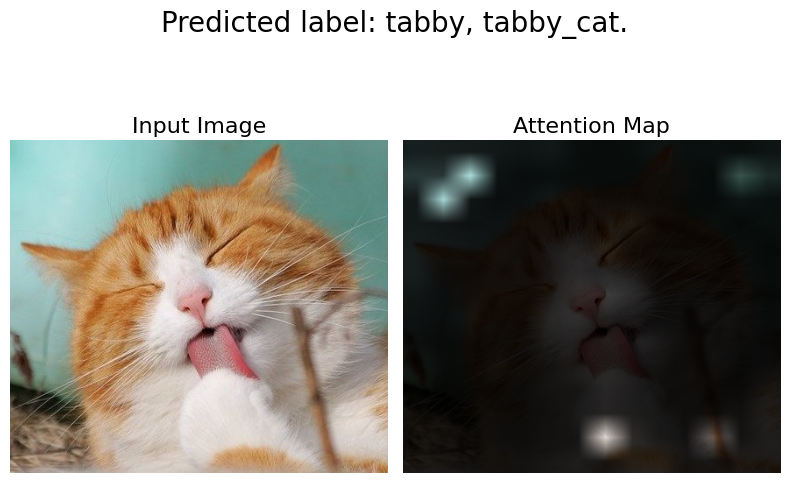

In [10]:
attn_rollout_result = attention_rollout_map(
    image, attention_score_dict, model_type="original_vit"
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 10))
fig.suptitle(f"Predicted label: {predicted_label}.", fontsize=20)

_ = ax1.imshow(image)
_ = ax2.imshow(attn_rollout_result)
ax1.set_title("Input Image", fontsize=16)
ax2.set_title("Attention Map", fontsize=16)
ax1.axis("off")
ax2.axis("off")

fig.tight_layout()
fig.subplots_adjust(top=1.35)
fig.show()

We can also visualise the attention weights of each individual attention head. The following code visualises the 12 attention heads in the final Transformer block.

In [11]:
def attention_heatmap(attention_score_dict, image, model_type="original_vit"):
    num_tokens = 2 if "distilled" in model_type else 1

    # Sort the Transformer blocks in order of their depth.
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-2]), reverse=True)

    # Process the attention maps for overlay.
    w_featmap = image.shape[2] // PATCH_SIZE
    h_featmap = image.shape[1] // PATCH_SIZE

    # Select attention scores from the final Transformer block
    # Note that blocks are in reverse order, so 0 is last, 1 is second-to-last
    attention_scores = attention_score_dict[attention_score_list[0]]

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, num_tokens:].reshape(num_heads, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))

    # Resize the attention patches to 224x224 (224: 14x16).
    attentions = ops.image.resize(
        attentions, size=(h_featmap * PATCH_SIZE, w_featmap * PATCH_SIZE)
    )
    return attentions

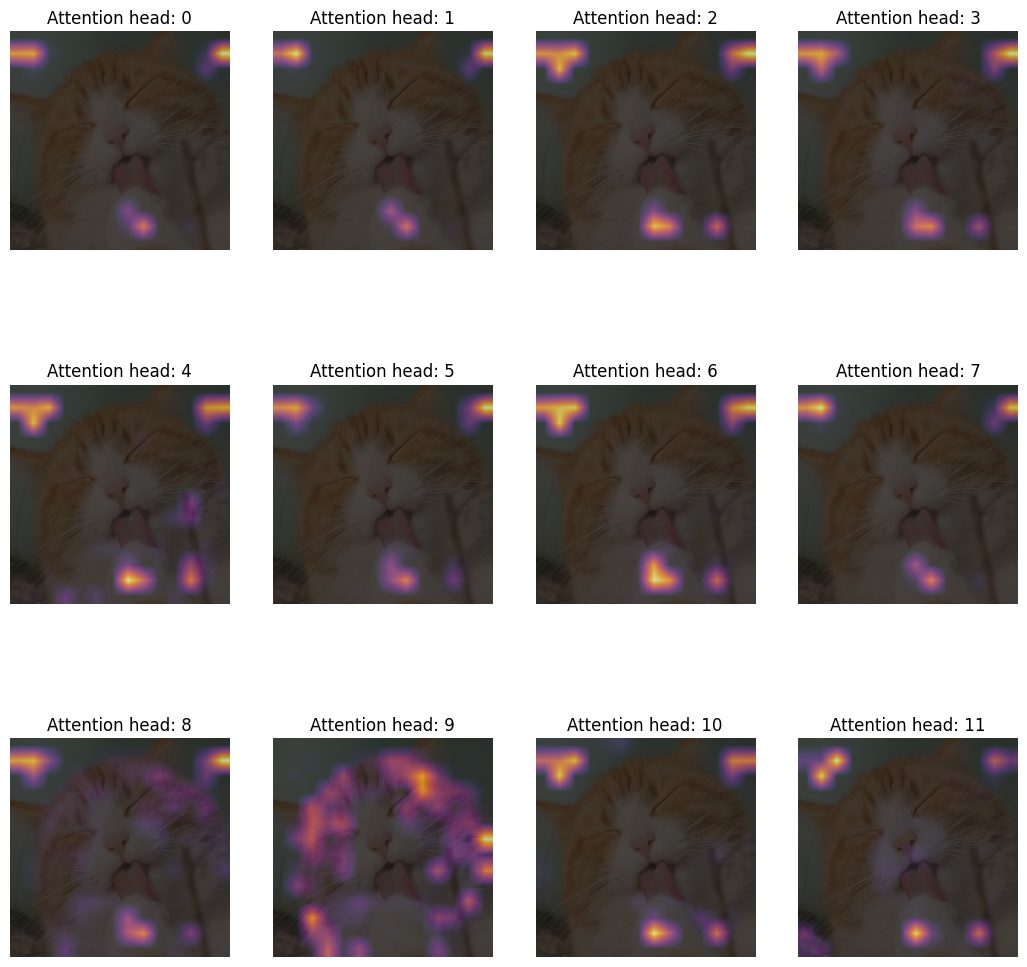

In [12]:
# De-normalize the image for visual clarity.
in1k_mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])
in1k_std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255])
preprocessed_img_orig = (preprocessed_image * in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.0
preprocessed_img_orig = ops.convert_to_numpy(ops.clip(preprocessed_img_orig, 0.0, 1.0))

# Generate the attention heatmaps.
attentions = attention_heatmap(attention_score_dict, preprocessed_img_orig)

# Plot the maps.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(4):
        if img_count < len(attentions):
            axes[i, j].imshow(preprocessed_img_orig[0])
            axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.6)
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1

### Exercise 4

Investigate how the attention pattern changes for (a) different images and (b) the final transformer layer versus an earlier one.

# 2 Grad-CAM visualization

In this section, we will display how to obtain a class activation heatmap for an image classification model. We do that using a method called [Grad-CAM](https://arxiv.org/abs/1610.02391). Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept, flowing into the final convolutional layer to produce a coarse localization map highlighting important regions in the image for predicting the concept. 

For visualization purposes, we will continue to use the VGG19 model loaded in the previous section. Reference source for the content of this section: Keras.

### The Grad-CAM algorithm

In [13]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import matplotlib.cm as cm

# Build a VGG19 model loaded with pre-trained ImageNet weights
model = VGG19(weights='imagenet') 

model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,31

 Total params: 143,667,240 (548.05 MB)

 Trainable params: 143,667,240 (548.05 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Next, we are going to make a prediction about our sample image. To get the values for `last_conv_layer_name` use `model.summary()` to see the names of all layers in the model.

In [15]:
# Define a function to process the input image
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = image.load_img(img_path, target_size=size)
    # Convert the image pixels to a numpy array
    # if size is (224,224), `array` is a float32 Numpy array of shape (224, 224, 3)
    array = image.img_to_array(img)
    # Reshape data for the model
    # We add a dimension to transform our array into a "batch" of size (1, 224, 224, 3)
    # Convert the input to 4D input makes it the same as the training process,
    # with a placeholder, rows, cols, the number of colour channels as training process
    array = np.expand_dims(array, axis=0)
    # axis: Position in the expanded axes where the new axis (or axes) is placed.
    # axis = 0: insert axis at position 0 
    return array

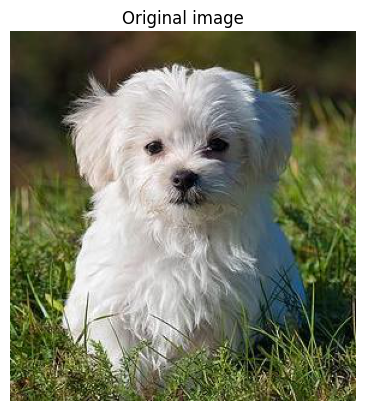

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Maltese_dog: 18.357%
Class ID: [153]


In [16]:
last_conv_layer_name = "block5_conv4"

img_name = "maltese.jpeg"

# Display the image
im = plt.imread(img_name)
plt.imshow(im)
plt.title('Original image')
plt.axis('off')
plt.show()

# Prepare image for the model
img_size = (224,224)
img_array = preprocess_input(get_img_array(img_name, size=img_size))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
for pred in decode_predictions(preds, top=1)[0]: 
    # print as labels: probability
    print('%s: %.3f%%' % (pred[1], pred[2]))
print("Class ID:" ,np.argsort(preds)[0, ::-1][:1])

Indeed there is a Maltese dog in the image. The `class ID` (index into the output layer) 153 stands for Maltese dog in [ImageNet with 1000 classes](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a#file-imagenet1000_clsidx_to_labels-txt-L154). But how does the network know this? Let's classify our images and see where the network "looks" when it does so.

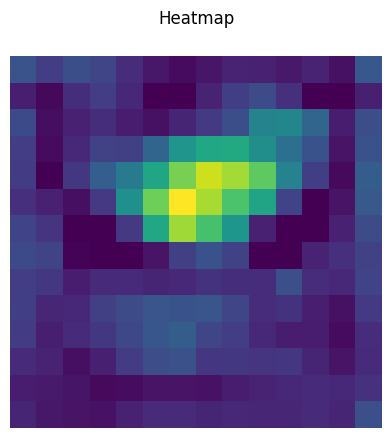

In [17]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.title('Heatmap')
plt.axis('off')
plt.show()

In [18]:
# Define a function to create a superimposed visualization
def display_gradcam(img_name, heatmap, alpha=0.4):

    # Load the original image
    img = image.load_img(img_name)
    img = image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Display superimpose result
    plt.matshow(superimposed_img)
    plt.title('Superimpose')
    plt.axis('off')
    plt.show()

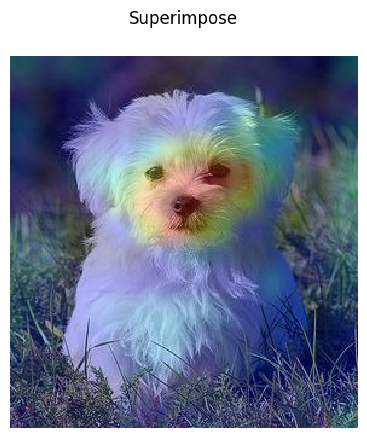

In [19]:
display_gradcam(img_name, heatmap, alpha=0.4)

### Exercise 5: Choosing the target class (target prediction) for Grad-CAM

We will see how the grad cam explains the model's outputs for a multi-label image. Let's try an image with different fruits together, and see how the Grad-CAM behaves. Please generate Grad-CAM heatmaps for the top2 predicted  categories separately.

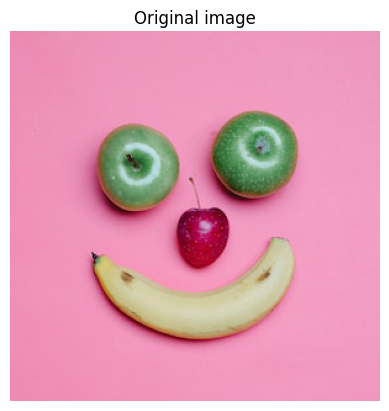

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Granny_Smith: 10.539%
banana: 8.362%
Class ID: [948 954]


In [20]:
img_name = "fruits.jpg"

# Display the image
im = plt.imread(img_name)
plt.imshow(im)
plt.title('Original image')
plt.axis('off')
plt.show()

# Prepare image for the model
img_array = preprocess_input(get_img_array(img_name, size=img_size))

# Print what the top2 predicted categories are
preds = model.predict(img_array)
for pred in decode_predictions(preds, top=2)[0]: 
    # print as labels: probability
    print('%s: %.3f%%' % (pred[1], pred[2]))
print("Class ID:" ,np.argsort(preds)[0, ::-1][:2])    

First, we generate class activation heatmap for "Granny_Smith," the class index is 948.

In [21]:
## You code


Then we generate class activation heatmap for "banana," the class index is 954.

In [22]:
## You code
